# score
A film's score adds emotional impact to the action onscreen. *King Kong* (1933) was the first film to incorporate a full orchestra score, adding weight to Kong's rampage. The famous shower scene in *Pyscho* (1960) wouldn't be nearly as frightening without the violin screeches. And the two notes of the shark's theme in *Jaws* (1975) was a big source of suspense for the POV underwater stalking scenes.

In [1]:
import librosa
from librosa.display import waveplot, specshow
import matplotlib.pyplot as plt
import numpy as np
from pychord import Chord, note_to_chord
from pychord.utils import val_to_note
from pychord.constants import scales

First, we'll take a look at what we can understand from "Alone in Kyoto", a song in *Lost in Translation* (2003). *Lost in Translation*, a film about loneliness and isolation, benefits from a score with heavy use of shoegaze: slow, ethereal, and introspective.

"Alone in Kyoto", by the electronic group Air, is a slow, minimalistic song that accompanies Scarlett Johansson's character as she wanders through Japanese temples alone, taking in the foreign sights and customs.

In [2]:
audio_file = ('../extracted_audio/score/kyoto.wav')

In [3]:
y, sr = librosa.load(audio_file)

## Visualizations
There are no diagetic (in-story) sounds in this part of the film; only the music is being analyzed. We can generate the waveplot and chromagram to visualize the song.

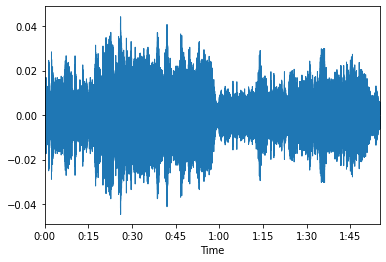

In [4]:
waveplot(y, sr)

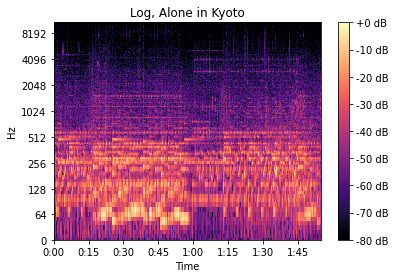

In [5]:
D = librosa.stft(y)
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
fig, ax = plt.subplots()
img = librosa.display.specshow(S_db, x_axis='time', y_axis='log', ax=ax)
ax.set(title='Log, Alone in Kyoto')
fig.colorbar(img, ax=ax, format="%+2.f dB")

## Tempo
`librosa` can estimate the tempo — it clocks in at a slow 89 beats per minute (BPM).

In [6]:
librosa.beat.tempo(y, sr)

array([89.10290948])

## Chromagram and chroma features
The chroma features can be extracted to estimate with notes/pitch classes are present at each time window. The chromagram provides a visualization — it looks like the D note is the most prevalent.

[Text(0.5, 1.0, 'Chromagram, Alone in Kyoto')]

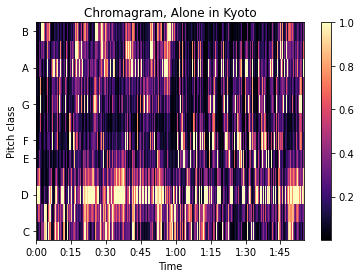

In [7]:
chroma = librosa.feature.chroma_stft(y, sr)
fig, ax = plt.subplots()
img = librosa.display.specshow(chroma, y_axis='chroma', x_axis='time', ax=ax)
fig.colorbar(img, ax=ax)
ax.set(title='Chromagram, Alone in Kyoto')

`chroma_stft()` returns an array of intensities for each of the 12 notes. Again, D is the most prevalent.

In [8]:
chroma.shape

(12, 4953)

In [9]:
chroma[0].mean() # mean intensity for C notes

0.40061817

In [10]:
chroma[2].mean() # mean intensity for D notes

0.6281621

We can `reshape()` this array to see each of the 12 pitches' intensities at a given time window.

In [11]:
chroma_window = chroma.reshape(4953, 12)

In [12]:
chroma_window[0]

array([0.07661644, 0.02667749, 0.03230091, 0.08452199, 0.08287171,
       0.05250483, 0.2567601 , 1.        , 1.        , 1.        ,
       1.        , 1.        ], dtype=float32)

### Major and Minor Scales
We'll want to evaluate how the score directs our emotional response. At its most simplified level, the score music is happy or sad. As a general, broad rule of thumb, music composed in major scales are happy, and and music composed in minor scales are sad.

Scales are composed of seven of the 12 pitch classes. Using chroma_stft() gives us the mean intensity of all 12, making a best effort to group audio data into the 12 pitch classes. By looking at the list of top seven, we may be able to map these to major and minor scales.

In [13]:
note_means = []
for note in chroma:
    note_means.append(note.mean())

In [14]:
note_means = np.array(note_means)

In [15]:
note_means.argsort()[-7:][::-1]

array([ 2,  1,  0,  9,  3,  5, 10])

### Major and Minor Chords
We may also want to identify major and minor chords. Again, major chords are happy, and minor chords sad. Chords are made of three or four individual notes to create (what sounds like) a single tone.

Here, we can find a minor chord, the diminished triad for the root note C (Cdim) in a French-inspired scene transition in *The Hustle*.

In [16]:
audio_file = ('../extracted_audio/score/french_transition.wav')
y, sr = librosa.load(audio_file)
chroma = librosa.feature.chroma_stft(y, sr)
chroma_window = chroma.reshape(862, 12)

For each time window, we can look for each pitch above a certain intensity. In the below example, we found three semitones in this window, index numbers 0, 3, 6, corresponding to the notes C, E-flat, and G-flat.

In [17]:
frame_semitones = np.argwhere(chroma_window[205] > 0.6)
frame_semitones

array([[0],
       [3],
       [6]])

We can make use of the `pychord` library to look up notes. By passing in the semitone numbers, we can convert these to notes using `val_to_note(), and then use the `note_to_chord` function to confirm that these notes correspond with the C diminished triad.

In [18]:
frame_notes = []
for note in frame_semitones[:,0]:
    frame_notes.append(val_to_note(note))

frame_notes

['C', 'Eb', 'Gb']

In [19]:
note_to_chord(frame_notes)

[<Chord: Cdim>]

### Scale Identification
In an earlier section, we simply attempted to calculate whether a scale was minor or major. But we may want to identify the specific root note, (e.g. identifying A minor instead of just a generic minor scale). Some music theorists believe that each root note evokes different feelings, so we may want to be more specific.

The `pychord` library doesn't have built-in functions to identify scales, but it does have reference dictionaries for chord calculations. We can use these dictionaries to calculate the notes for any given pitch and major/minor combination. Below we can look up the notes for the A minor scale.

In [20]:
scale_notes = []
minor_major = 'min'
root_pitch = 'A'

for semitone in scales.RELATIVE_KEY_DICT[minor_major]:
    scale_notes.append(scales.SCALE_VAL_DICT[root_pitch][(semitone + scales.NOTE_VAL_DICT[root_pitch])%12])

scale_notes

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'A']